In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/gateway_final_project/merged data.csv')

In [ ]:
df.head()

,Unnamed: 0,timestamp_local,DEP_DELAY,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,...,timestamp_utc,ts,uv,vis,weather/description,weather/code,weather/icon,wind_dir,wind_gust_spd,wind_spd
0,0,2018-01-01T15:15:00,-5.0,-14.9,210.66,0,-22.5,76.57,722.62,20.0,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
1,1,2018-01-01T15:15:00,36.0,-14.9,210.66,0,-22.5,76.57,722.62,20.0,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
2,2,2018-01-01T15:15:00,47.0,-14.9,210.66,0,-22.5,76.57,722.62,20.0,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
3,3,2018-01-01T15:15:00,28.0,-14.9,210.66,0,-22.5,76.57,722.62,20.0,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
4,4,2018-01-01T15:15:00,7.0,-14.9,210.66,0,-22.5,76.57,722.62,20.0,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8


In [ ]:
def format_df(df): # formats df by getting rid of extra columns and making negative delays = 0
  df_copy = df.copy()
  for i in range(len(df_copy['DEP_DELAY'])):
    if df_copy['DEP_DELAY'][i] < 0:    
      df_copy['DEP_DELAY'][i]=0
  df_copy.drop(['Unnamed: 0','timestamp_utc'],axis=1)
  return df_copy

In [ ]:
formatted_df = format_df(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
def predict_mlp_classifier_precip_rate(df):
  df_train = df.iloc[:5629, :] #x is precipitation and y is delay
  df_test = df.iloc[5629:, :]
  for i in range(len(df['DEP_DELAY'])): # for this model, if the flight was cancelled, we set the delay to -1
    if math.isnan(df['DEP_DELAY'][i]):
      df['DEP_DELAY'][i]=-1
  df_train_y = df_train[['DEP_DELAY']]
  df_train_x = df_train[['precip_rate']]
  model = MLPClassifier(hidden_layer_sizes=(8,9,9), activation='relu', max_iter=5000)
  model.fit(df_train_x, df_train_y)
  print("score:", model.score(df_train_x, df_train_y)) # this is for comparing delay to precipitation (where delay =0 means no delay and delay = -1 means cancelled)

In [ ]:
predict_mlp_classifier_precip_rate(formatted_df) #score: 0.46704565642209983

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score: 0.46704565642209983


In [ ]:
def predict_mlp_classifier_temp(df):
  df_train = df.iloc[:5629, :] #x is temp and y is delay
  df_test = df.iloc[5629:, :]
  for i in range(len(df['DEP_DELAY'])):
    if df['DEP_DELAY'][i]==-1:
      df['DEP_DELAY'][i]=300
  df_train_y = df_train[['DEP_DELAY']]
  df_train_x = df_train[['temp']]
  model = MLPClassifier(hidden_layer_sizes=(8,9,9), activation='relu', max_iter=5000)
  model.fit(df_train_x, df_train_y)
  print("score:", model.score(df_train_x, df_train_y)) # this is for comparing delay to temp 

In [ ]:
predict_mlp_classifier_temp(formatted_df) #score: 0.46722330786995914

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score: 0.46633505063066266


In [ ]:
def predict_logistic_regression(df):
  features = ['precip_rate', 'wind_spd']
  X = df[features]
  df['cancelled'] = ''
  for i in range(len(df['DEP_DELAY'])): # adding 'cancelled' column
    if(np.isnan(df['DEP_DELAY'][i])):
      df['cancelled'][i]=True
      df['DEP_DELAY'][i] = -1
    #else:
      #df['cancelled'][i]=False
  #y = df['cancelled']
  y = df['DEP_DELAY']
  print(y)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  log = LogisticRegression(class_weight='balanced')
  log.fit(X_scaled,y)
  print("score:", log.score(X_scaled,y))
  return df #score: 0.0014212115828744004

In [ ]:
formatted_df = format_df(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
predict_logistic_regression(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0        -5.0
1        36.0
2        47.0
3        28.0
4         7.0
         ... 
11253    -7.0
11254    -8.0
11255    -4.0
11256   -10.0
11257    -6.0
Name: DEP_DELAY, Length: 11258, dtype: float64
score: 0.0014212115828744004


,Unnamed: 0,timestamp_local,DEP_DELAY,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,...,ts,uv,vis,weather/description,weather/code,weather/icon,wind_dir,wind_gust_spd,wind_spd,cancelled
0,0,2018-01-01T15:15:00,-5.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8,
1,1,2018-01-01T15:15:00,36.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8,
2,2,2018-01-01T15:15:00,47.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8,
3,3,2018-01-01T15:15:00,28.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8,
4,4,2018-01-01T15:15:00,7.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11253,11253,2018-01-30T20:45:00,-7.0,-24.6,269.70,4,-22.5,0.00,0.00,-27.59,...,1517323500,0.0,16,Few clouds,801,c02n,102,1.7,1.6,
11254,11254,2018-01-30T20:45:00,-8.0,-24.6,269.70,4,-22.5,0.00,0.00,-27.59,...,1517323500,0.0,16,Few clouds,801,c02n,102,1.7,1.6,
11255,11255,2018-01-30T11:15:00,-4.0,-19.8,147.41,100,-18.2,84.88,782.17,24.88,...,1517289300,0.7,16,Light snow,600,s01d,132,1.7,1.6,
11256,11256,2018-01-30T05:00:00,-10.0,-21.7,81.52,98,-19.1,0.00,0.00,-37.73,...,1517266800,0.0,16,Overcast clouds,804,c04n,118,2.5,2.4,


In [ ]:
def predict_logistic_regression_with_negative_delays_as_0(df):
  features = ['precip_rate', 'wind_spd']
  X = df[features]
  df['cancelled'] = ''
  for i in range(len(df['DEP_DELAY'])): # adding 'cancelled' column
    if(np.isnan(df['DEP_DELAY'][i])):
      df['cancelled'][i]=True
      df['DEP_DELAY'][i] = -1
    if(df["DEP_DELAY"][i] < 0):
      df["DEP_DELAY"][i] = 0
    #else:
      #df['cancelled'][i]=False
  #y = df['cancelled']
  y = df['DEP_DELAY']
  print(y)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  log = LogisticRegression(class_weight='balanced', max_iter=10000)
  log.fit(X_scaled,y)
  print("score:", log.score(X_scaled,y))
  return df #score: 0.0013323858589447503

In [ ]:
formatted_df = format_df(df)

NameError: ignored

In [ ]:
predict_logistic_regression_with_negative_delays_as_0(formatted_df)

0         0.0
1        36.0
2        47.0
3        28.0
4         7.0
         ... 
11253     0.0
11254     0.0
11255     0.0
11256     0.0
11257     0.0
Name: DEP_DELAY, Length: 11258, dtype: float64
score: 0.0013323858589447503


,Unnamed: 0,timestamp_local,DEP_DELAY,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,...,ts,uv,vis,weather/description,weather/code,weather/icon,wind_dir,wind_gust_spd,wind_spd,cancelled
0,0,2018-01-01T15:15:00,0.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8,
1,1,2018-01-01T15:15:00,36.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8,
2,2,2018-01-01T15:15:00,47.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8,
3,3,2018-01-01T15:15:00,28.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8,
4,4,2018-01-01T15:15:00,7.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11253,11253,2018-01-30T20:45:00,0.0,-24.6,269.70,4,-22.5,0.00,0.00,-27.59,...,1517323500,0.0,16,Few clouds,801,c02n,102,1.7,1.6,
11254,11254,2018-01-30T20:45:00,0.0,-24.6,269.70,4,-22.5,0.00,0.00,-27.59,...,1517323500,0.0,16,Few clouds,801,c02n,102,1.7,1.6,
11255,11255,2018-01-30T11:15:00,0.0,-19.8,147.41,100,-18.2,84.88,782.17,24.88,...,1517289300,0.7,16,Light snow,600,s01d,132,1.7,1.6,
11256,11256,2018-01-30T05:00:00,0.0,-21.7,81.52,98,-19.1,0.00,0.00,-37.73,...,1517266800,0.0,16,Overcast clouds,804,c04n,118,2.5,2.4,


In [ ]:
def predict_logistic_regression_without_cancellations(df):
  features = ['precip_rate', 'wind_spd']
  X = df[features]
  df.dropna()
  for i in range(len(df['DEP_DELAY'])): 
    if(np.isnan(df['DEP_DELAY'][i])):
      df['DEP_DELAY'][i] = -1
    if(df["DEP_DELAY"][i] < 0):
      df["DEP_DELAY"][i] = 0
  y = df['DEP_DELAY']
  print(y)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  log = LogisticRegression(class_weight='balanced', max_iter=10000)
  log.fit(X_scaled,y)
  print("score:", log.score(X_scaled,y))
  return df #score: 0.0013323858589447503

In [ ]:
formatted_df = format_df(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
predict_logistic_regression_without_cancellations(formatted_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


0         0.0
1        36.0
2        47.0
3        28.0
4         7.0
         ... 
11253     0.0
11254     0.0
11255     0.0
11256     0.0
11257     0.0
Name: DEP_DELAY, Length: 11258, dtype: float64
score: 0.0013323858589447503


,Unnamed: 0,timestamp_local,DEP_DELAY,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,...,timestamp_utc,ts,uv,vis,weather/description,weather/code,weather/icon,wind_dir,wind_gust_spd,wind_spd
0,0,2018-01-01T15:15:00,0.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
1,1,2018-01-01T15:15:00,36.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
2,2,2018-01-01T15:15:00,47.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
3,3,2018-01-01T15:15:00,28.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
4,4,2018-01-01T15:15:00,7.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11253,11253,2018-01-30T20:45:00,0.0,-24.6,269.70,4,-22.5,0.00,0.00,-27.59,...,2018-01-30T14:45:00,1517323500,0.0,16,Few clouds,801,c02n,102,1.7,1.6
11254,11254,2018-01-30T20:45:00,0.0,-24.6,269.70,4,-22.5,0.00,0.00,-27.59,...,2018-01-30T14:45:00,1517323500,0.0,16,Few clouds,801,c02n,102,1.7,1.6
11255,11255,2018-01-30T11:15:00,0.0,-19.8,147.41,100,-18.2,84.88,782.17,24.88,...,2018-01-30T05:15:00,1517289300,0.7,16,Light snow,600,s01d,132,1.7,1.6
11256,11256,2018-01-30T05:00:00,0.0,-21.7,81.52,98,-19.1,0.00,0.00,-37.73,...,2018-01-29T23:00:00,1517266800,0.0,16,Overcast clouds,804,c04n,118,2.5,2.4


In [ ]:
def predict_logistic_regression_without_cancellations_no_standardscaler(df):
  features = ['precip_rate', 'wind_spd']
  X = df[features]
  df.dropna()
  for i in range(len(df['DEP_DELAY'])): 
    if(np.isnan(df['DEP_DELAY'][i])):
      df['DEP_DELAY'][i] = -1
    if(df["DEP_DELAY"][i] < 0):
      df["DEP_DELAY"][i] = 0
  y = df['DEP_DELAY']
  print(y)
  #scaler = StandardScaler()
  #X_scaled = scaler.fit_transform(X)
  log = LogisticRegression(class_weight='balanced', max_iter=10000)
  log.fit(X,y)
  print("score:", log.score(X,y))
  return df #score: 0

In [ ]:
predict_logistic_regression_without_cancellations_no_standardscaler(formatted_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


0         0.0
1        36.0
2        47.0
3        28.0
4         7.0
         ... 
11253     0.0
11254     0.0
11255     0.0
11256     0.0
11257     0.0
Name: DEP_DELAY, Length: 11258, dtype: float64
score: 0.0013323858589447503


,Unnamed: 0,timestamp_local,DEP_DELAY,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,...,timestamp_utc,ts,uv,vis,weather/description,weather/code,weather/icon,wind_dir,wind_gust_spd,wind_spd
0,0,2018-01-01T15:15:00,0.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
1,1,2018-01-01T15:15:00,36.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
2,2,2018-01-01T15:15:00,47.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
3,3,2018-01-01T15:15:00,28.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
4,4,2018-01-01T15:15:00,7.0,-14.9,210.66,0,-22.5,76.57,722.62,20.00,...,2018-01-01T09:15:00,1514798100,1.8,16,Clear Sky,800,c01d,125,0.8,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11253,11253,2018-01-30T20:45:00,0.0,-24.6,269.70,4,-22.5,0.00,0.00,-27.59,...,2018-01-30T14:45:00,1517323500,0.0,16,Few clouds,801,c02n,102,1.7,1.6
11254,11254,2018-01-30T20:45:00,0.0,-24.6,269.70,4,-22.5,0.00,0.00,-27.59,...,2018-01-30T14:45:00,1517323500,0.0,16,Few clouds,801,c02n,102,1.7,1.6
11255,11255,2018-01-30T11:15:00,0.0,-19.8,147.41,100,-18.2,84.88,782.17,24.88,...,2018-01-30T05:15:00,1517289300,0.7,16,Light snow,600,s01d,132,1.7,1.6
11256,11256,2018-01-30T05:00:00,0.0,-21.7,81.52,98,-19.1,0.00,0.00,-37.73,...,2018-01-29T23:00:00,1517266800,0.0,16,Overcast clouds,804,c04n,118,2.5,2.4


In [ ]:
df_final = pd.read_csv('/content/drive/My Drive/gateway_final_project/finalcsv.csv')

In [ ]:
df_final.head()

,Unnamed: 0,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,ghi,pod,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 27
0,0,-23.6,110.14,12,-20.2,0.00,0.00,-12.14,0.0,n,...,174.0,180.0,158.0,1065.0,0.0,13.0,6.0,0.0,0.0,NaN
1,1,-22.2,126.81,25,-19.9,37.63,322.62,5.40,58.3,d,...,178.0,174.0,149.0,937.0,0.0,18.0,0.0,0.0,0.0,NaN
2,2,-17.4,172.38,25,-19.1,90.36,764.91,25.55,413.6,d,...,156.0,163.0,128.0,746.0,0.0,12.0,7.0,0.0,0.0,NaN
3,3,-15.0,224.85,25,-21.6,58.88,521.80,11.74,163.6,d,...,182.0,197.0,170.0,1023.0,0.0,1.0,15.0,0.0,6.0,NaN
4,4,-15.0,224.85,25,-21.6,58.88,521.80,11.74,163.6,d,...,83.0,80.0,61.0,393.0,0.0,278.0,0.0,0.0,0.0,NaN


In [ ]:
df_final.shape

(1699, 67)

In [ ]:
print(df_final['weather/description'])

0             Few clouds
1       Scattered clouds
2       Scattered clouds
3       Scattered clouds
4       Scattered clouds
              ...       
1694     Overcast clouds
1695       Broken clouds
1696          Light rain
1697          Light rain
1698          Light rain
Name: weather/description, Length: 1699, dtype: object


In [ ]:
df_final['weather/description'].value_counts()

Overcast clouds                 548
Light rain                      354
Broken clouds                   170
Scattered clouds                155
Moderate rain                    81
Light snow                       69
Thunderstorm with heavy rain     69
Snow                             56
Heavy rain                       53
Clear Sky                        50
Fog                              27
Sleet                            22
Mix snow/rain                    17
Few clouds                       16
Heavy snow                        6
Haze                              4
Freezing rain                     2
Name: weather/description, dtype: int64

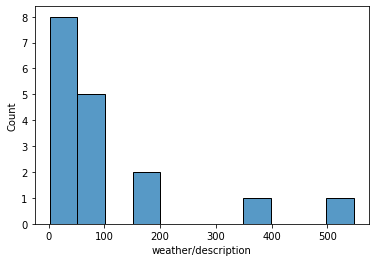

In [ ]:
sns.histplot(data=df_final['weather/description'].value_counts())

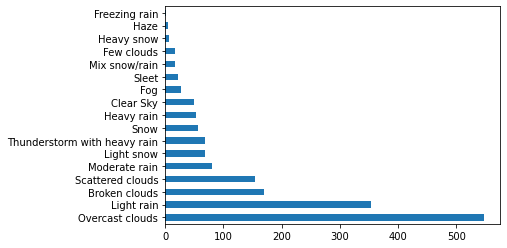

In [ ]:
df_final['weather/description'].value_counts().plot(kind='barh')

In [ ]:
print(df_final.loc[df_final['weather/description']=="Overcast clouds"])

      Unnamed: 0  app_temp  azimuth  clouds  dewpt   dhi     dni  elev_angle  \
17            17      -4.1   164.49      87  -17.9  89.3  758.15       24.92   
18            18      -6.5   247.60      87  -12.9   0.0    0.00       -9.18   
19            19      -3.7   267.97     100  -11.2   0.0    0.00      -33.97   
20            20      -5.8   284.82     100  -11.0   0.0    0.00      -50.80   
22            22     -18.4   358.73      78  -15.0   0.0    0.00      -71.98   
...          ...       ...      ...     ...    ...   ...     ...         ...   
1682        1682      -1.0   316.91     100    1.8   0.0    0.00      -67.25   
1683        1683      -1.2   323.35     100    1.5   0.0    0.00      -69.43   
1691        1691      12.8   289.14      87   11.4   0.0    0.00      -54.96   
1693        1693       1.6   278.74      87   -3.5   0.0    0.00      -46.66   
1694        1694       1.5   281.48      87   -3.5   0.0    0.00      -49.48   

        ghi pod  ...  CRS_ELAPSED_TIME 

In [ ]:
print(df_final.groupby(['weather/description']).mean()['WEATHER_DELAY'])

weather/description
Broken clouds                    62.664706
Clear Sky                        89.620000
Few clouds                       35.312500
Fog                              49.777778
Freezing rain                   115.000000
Haze                             16.250000
Heavy rain                       66.037736
Heavy snow                      105.833333
Light rain                       66.423729
Light snow                      102.985507
Mix snow/rain                    99.588235
Moderate rain                    74.679012
Overcast clouds                  81.936131
Scattered clouds                 45.419355
Sleet                           137.545455
Snow                             70.857143
Thunderstorm with heavy rain     73.608696
Name: WEATHER_DELAY, dtype: float64


In [ ]:
df_avg_delay = df_final.groupby(['weather/description']).mean()['WEATHER_DELAY']

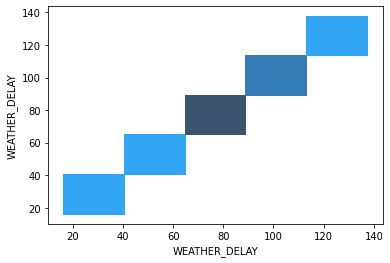

In [ ]:
sns.histplot(data=df_avg_delay, x=df_avg_delay[0:,], y=df_avg_delay[0:,])

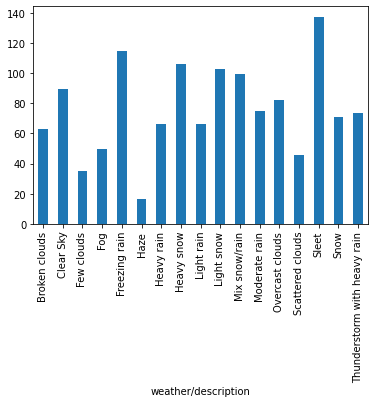

In [ ]:
df_avg_delay.plot(kind = "bar")

In [ ]:
df_avg_delay_greater_than_15 = df_final.loc[df_final['WEATHER_DELAY'] >= 15].groupby(['weather/description']).mean()['WEATHER_DELAY']

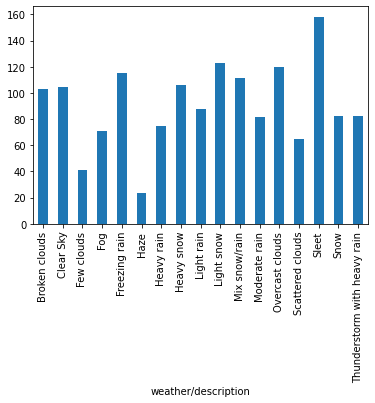

In [ ]:
df_avg_delay_greater_than_15.plot(kind = "bar")

In [ ]:
df_avg_delay_greater_than_60 = df_final.loc[df_final['WEATHER_DELAY'] >= 60].groupby(['weather/description']).mean()['WEATHER_DELAY']

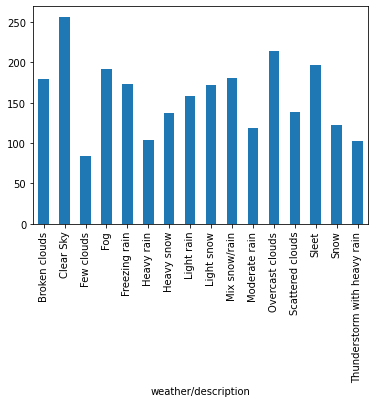

In [ ]:
df_avg_delay_greater_than_60.plot(kind = "bar")

In [ ]:
df_incl_0 = pd.read_csv('/content/drive/My Drive/gateway_final_project/finalcsvdropped (1).csv') # this is weather_delay >= 0

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (11,14,20,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_incl_0 = df_incl_0.dropna()
df_incl_0.shape
df_incl_0.head()

,Unnamed: 0,timestamp_local,WEATHER_DELAY,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,...,timestamp_utc,ts,uv,vis,weather/description,weather/icon,weather/code,wind_dir,wind_gust_spd,wind_spd
0,0,2018-01-01T19:15:00,0.0,-14.1,263.30,25.0,-20.7,0.0,0.00,-28.59,...,2018-01-02T00:15:00,1.514852e+09,0.0,16.0,Scattered clouds,c02n,802.0,270.0,3.9,3.60
1,1,2018-01-01T00:00:00,0.0,-22.3,0.11,18.0,-20.6,0.0,0.00,-72.36,...,2018-01-01T05:00:00,1.514783e+09,0.0,16.0,Few clouds,c02n,801.0,325.0,8.0,6.82
2,2,2018-01-01T23:45:00,9.0,-17.5,349.78,25.0,-16.9,0.0,0.00,-71.26,...,2018-01-02T04:45:00,1.514868e+09,0.0,16.0,Scattered clouds,c02n,802.0,250.0,5.7,5.09
3,3,2018-01-01T19:45:00,0.0,-14.1,267.93,25.0,-20.0,0.0,0.00,-34.25,...,2018-01-02T00:45:00,1.514854e+09,0.0,16.0,Scattered clouds,c02n,802.0,250.0,3.9,3.60
4,4,2018-01-01T14:45:00,0.0,-14.6,218.90,25.0,-21.0,69.7,616.27,15.50,...,2018-01-01T19:45:00,1.514836e+09,1.2,16.0,Scattered clouds,c02d,802.0,320.0,11.3,7.20


In [ ]:
print(df_incl_0.groupby(['weather/description']).mean()['WEATHER_DELAY'])

weather/description
Broken clouds                    2.244154
Clear Sky                        5.162442
Few clouds                       1.587079
Flurries                         0.000000
Fog                              1.220708
Freezing rain                   19.166667
Haze                             0.273109
Heavy rain                      17.241379
Heavy snow                      52.916667
Light rain                       6.356853
Light snow                      27.019011
Mix snow/rain                   12.540741
Moderate rain                   29.081731
Overcast clouds                  2.555695
Scattered clouds                 1.674197
Sleet                           38.794872
Snow                            27.365517
Thunderstorm with heavy rain    57.067416
Name: WEATHER_DELAY, dtype: float64


In [ ]:
df_avg_delay_0 = df_incl_0.groupby(['weather/description']).mean()['WEATHER_DELAY']

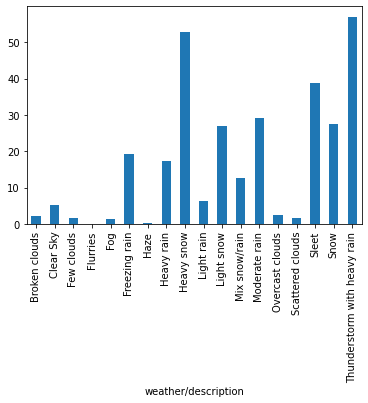

In [ ]:
df_avg_delay_0.plot(kind = "bar")

In [ ]:
def predict_mlp_classifier_precip_rate(df):
  df=df.dropna()
  df_train_y = df[['WEATHER_DELAY']]
  df_train_x = df[['precip_rate']]
  model = MLPClassifier(hidden_layer_sizes=(8,9,9), activation='relu', max_iter=5000)
  model.fit(df_train_x, df_train_y)
  print("score:", model.score(df_train_x, df_train_y)) #score: 0.9499484460156135

In [ ]:
predict_mlp_classifier_precip_rate(df_incl_0)

       precip_rate
0              0.0
1              0.0
2              0.0
3              0.0
4              0.0
...            ...
34705          0.0
34706          0.0
34707          0.0
34708          0.0
34709          0.0

[33945 rows x 1 columns]


/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score: 0.9499484460156135


In [ ]:
def predict_mlp_classifier_weather_description(df):
  df=df.dropna()
  y = df[['WEATHER_DELAY']]
  #df_train_x = df[['precip_rate']]
  X  = pd.factorize(df['weather/description'])[0].reshape(-1, 1)
  #X = df[['precip_rate']]
  #print(df_train_x) 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50)
  model = MLPClassifier(hidden_layer_sizes=(8,9,8), activation='relu', max_iter=5000)
  model.fit(X_train, y_train)
  predict_train = model.predict(X_train)
  predict_test = model.predict(X_test)
  print(confusion_matrix(y_test, predict_test))
  print(classification_report(y_test, predict_test))
  
  #print("score:", model.score(df_train_x, df_train_y)) #score: 0.9499484460156135
#df_incl_0 = df_incl_0.dropna()
#print(df_incl_0['weather/description'])
#weather_factorized = pd.factorize(df_incl_0['weather/description'])
#print(weather_factorized[1])

In [ ]:
predict_mlp_classifier_weather_description(df_incl_0)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[16131     0     0 ...     0     0     0]
 [   22     0     0 ...     0     0     0]
 [   15     0     0 ...     0     0     0]
 ...
 [    1     0     0 ...     0     0     0]
 [    1     0     0 ...     0     0     0]
 [    1     0     0 ...     0     0     0]]
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     16131
         1.0       0.00      0.00      0.00        22
         2.0       0.00      0.00      0.00        15
         3.0       0.00      0.00      0.00        27
         4.0       0.00      0.00      0.00        16
         5.0       0.00      0.00      0.00        14
         6.0       0.00      0.00      0.00        15
         7.0       0.00      0.00      0.00        21
         8.0       0.00      0.00      0.00        13
         9.0       0.00      0.00      0.00        17
        10.0       0.00      0.00      0.00        13
        11.0       0.00      0.00      0.00        21
        12.0       0.00      0.00

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def predict_delayed_standard_scalar(df):
  #df = df.dropna()
  df['delayed'] = 0
  #df['weather_factorized'] = 0
  df_train_x  = pd.factorize(df['weather/description'])[0].reshape(-1, 1)
  for i in range(len(df['WEATHER_DELAY'])):

    if df['WEATHER_DELAY'][i] > 10:
      df['delayed'][i] = True
    else:
      df['delayed'][i] = False
  df['weather_factorized'] = df_train_x
  df = df.dropna()
  features = ['weather_factorized', 'precip_rate']
  X = df[features]
  y = df['delayed'].astype('int')
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  log = LogisticRegression(class_weight='balanced')
  print(np.mean(cross_val_score(log,X_scaled,y,cv=5,scoring='f1'))) #score: 0.17992376849506816
  
  

In [ ]:
predict_delayed_standard_scalar(df_incl_0)

<ipython-input-75-8142ad8bb3bc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delayed'][i] = False
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.17992376849506816


In [ ]:
df_incl_0.head()

,Unnamed: 0,timestamp_local,WEATHER_DELAY,app_temp,azimuth,clouds,dewpt,dhi,dni,elev_angle,...,ts,uv,vis,weather/description,weather/icon,weather/code,wind_dir,wind_gust_spd,wind_spd,delayed
0,0,2018-01-01T19:15:00,0.0,-14.1,263.30,25.0,-20.7,0.0,0.00,-28.59,...,1.514852e+09,0.0,16.0,Scattered clouds,c02n,802.0,270.0,3.9,3.60,False
1,1,2018-01-01T00:00:00,0.0,-22.3,0.11,18.0,-20.6,0.0,0.00,-72.36,...,1.514783e+09,0.0,16.0,Few clouds,c02n,801.0,325.0,8.0,6.82,False
2,2,2018-01-01T23:45:00,9.0,-17.5,349.78,25.0,-16.9,0.0,0.00,-71.26,...,1.514868e+09,0.0,16.0,Scattered clouds,c02n,802.0,250.0,5.7,5.09,False
3,3,2018-01-01T19:45:00,0.0,-14.1,267.93,25.0,-20.0,0.0,0.00,-34.25,...,1.514854e+09,0.0,16.0,Scattered clouds,c02n,802.0,250.0,3.9,3.60,False
4,4,2018-01-01T14:45:00,0.0,-14.6,218.90,25.0,-21.0,69.7,616.27,15.50,...,1.514836e+09,1.2,16.0,Scattered clouds,c02d,802.0,320.0,11.3,7.20,False


In [ ]:
def mlp_classifier_all(df):
  #df = df.dropna()
  df['delayed'] = 0
  weather_description  = pd.factorize(df['weather/description'])[0].reshape(-1, 1)
  for i in range(len(df['WEATHER_DELAY'])): #sets delayed = True if delay > 10 mins
    if df['WEATHER_DELAY'][i] > 10:
      df['delayed'][i] = True
    else:
      df['delayed'][i] = False
  df['weather_factorized'] = weather_description
  target_column = df['delayed']
  df=df.dropna()
  predictors = [df['weather_factorized'] , df['snow_rate'], df['precip_rate'], df['temp'], df['wind_spd']]
  df[predictors] = df[predictors]/df[predictors].max() #normalization
  X=df[predictors].values
  y=df[target_column].values
  X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)
  model=MLPClassifier(hidden_layer_sizes=(8,9,8),activation='relu', max_iter=5000)
  model.fit(X_train, y_train.ravel())
  predict_train = model.predict(X_train)
  predict_test = model.predict(X_test)
  print(confusion_matrix(y_train, predict_train))
  print(classification_report(y_train, predict_train))

In [ ]:
df_incl_0 = pd.read_csv('/content/drive/My Drive/gateway_final_project/finalcsvdropped (1).csv') # this is weather_delay >= 0

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (11,14,20,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
mlp_classifier_all(df_incl_0)

<ipython-input-26-37271b6a8cf0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delayed'][i] = False


KeyError: ignored